## SKOLTECH, Experimental Data Processing

## Evgenii Safronov, Mikhail Kurenkov, Taras Melnik

In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from numpy.linalg import inv
import matplotlib as mplb
from matplotlib.font_manager import FontProperties
%matplotlib inline
from numpy.random import normal
from mpl_toolkits.mplot3d import Axes3D
mplb.rc('xtick', labelsize=5) 
mplb.rc('ytick', labelsize=5) 

# Part 1
## Generating a trajectory

In [2]:
def generate_acc_trajectory(sigma_a_2, sigma_n_2, N, x_0, v_0, t, a_bias = 0):
    if sigma_a_2 == 0:
        a = np.zeros(N) + a_bias
    else:    
        a = np.random.normal(0, sigma_a_2 ** 0.5, N) + a_bias
    v = np.ones(N) * v_0
    x = np.ones(N) * x_0
    for i, a_i in enumerate(a[:-1]):
        v[i+1] = v[i] + a_i*t
    dx = (v * t + a * t * t / 2)
    for i, dx_i in enumerate(dx[:-1]):
        x[i+1] = x[i] + dx_i
    #v2 = np.ones(N) * v_0 + a.dot(np.triu(np.ones((N, N)), 1)) * t
    #x2 = np.ones(N) * x_0 + (v2 * t + a * t * t / 2).dot(np.triu(np.ones((N, N)), 1))
    z = x + np.random.normal(0, sigma_n_2 ** 0.5, N)
    return x, z

## Generating measurements

In [3]:
N = 500000
sigma_a = 3
q = 6
sigma_n = 10
x_1 = 5
v_1 = 1
t = 1
X_0 = np.array([[2],[0]])
P_0 = np.matrix([[10000, 0], [0,10000]])
G = np.array([[t**2/2], [t]])
H = np.array([[1, 0]])
Q = G.dot(G.transpose())*sigma_a**2
R = np.array([[sigma_n**2]])
T = np.matrix([[1, t],[0,1]])

In [4]:
x, z = generate_acc_trajectory(sigma_a**2, sigma_n**2, N, x_1, v_1, t, q)

## Identification of $q_{exp}$, $\sigma_a$, $\sigma_n$

In [5]:
v = z - 2*np.roll(z,1) +   np.roll(z,2)
p = z - 3*np.roll(z,2) + 2*np.roll(z,3)

E_v = np.average(v[2:])
E_p = np.average(p[3:])
q_exp = (E_v/t**2 + E_p/t**2/3)/2
E_v2= np.average(((v-q_exp*t**2)**2)[2:])
E_p2= np.average(((p-3*q_exp*t**2)**2)[3:])

exp_sigma_a_2 = E_p2/7*3 - E_v2
exp_sigma_n_2 = (7*E_v2 - E_p2)/28
print("experimental:\t q = %.2f,\t sigma_a = %.2f,\t sigma_n = %.2f"%(q_exp, exp_sigma_a_2**0.5,exp_sigma_n_2**0.5))
print(" model input:\t q = %.2f,\t sigma_a = %.2f,\t sigma_n = %.2f"%(q, sigma_a,sigma_n))

experimental:	 q = 6.01,	 sigma_a = 3.06,	 sigma_n = 10.00
 model input:	 q = 6.00,	 sigma_a = 3.00,	 sigma_n = 10.00


# Part 2
## Again trajectory

In [17]:
N = 200
sigma_a = 3
q = 6
sigma_n = 10
x_1 = 5
v_1 = 1
t = 1
X_0 = np.array([[2],[0]])
P_0 = np.matrix([[1e10, 0], [0,1e10]])
G = np.array([[t**2/2], [t]])
H = np.array([[1, 0]])
Q = G.dot(G.transpose())*exp_sigma_a_2
R = np.array([[exp_sigma_n_2]])
T = np.matrix([[1, t],[0,1]])

In [18]:
x, z = generate_acc_trajectory(sigma_a**2, sigma_n**2, N, x_1, v_1, t, q)

In [19]:
def kalman_biased(X_0, P_0, z, T, H, R, Q, Gq = 0, Kext = None):
    X = np.zeros((len(z),*(X_0.shape)))
    P = np.zeros((len(z),*(P_0.shape)))
    K = np.zeros_like(X) # ??? if z[i] not number
    XF= np.zeros_like(X)
    T6 = np.linalg.matrix_power(T,6)
    for i, _ in enumerate(z):
        #Prediction
        X[i] = T.dot(X[i-1] if i > 0 else X_0) + Gq
        P[i] = T.dot((P[i-1] if i > 0 else P_0).dot(T.transpose())) + Q
        #Filtration
        if Kext is None:
            tmp1 = inv(H.dot(P[i].dot(H.transpose())) + R)
            tmp2 = H.transpose().dot(tmp1)
            K[i] = P[i].dot(tmp2)
        else:
            K[i] = Kext[i]
        X[i] = X[i] + K[i]*(z[i] - H.dot(X[i]))
        P[i] = (np.identity(X_0.shape[0]) - K[i].dot(H)).dot(P[i])
        if i + 6 < len(z):
            XF[6 + i] = T6.dot(X[i])
    return X,K,P,XF

# Obtain the results

In [25]:
X, K, P, XF = kalman_biased(X_0, P_0, z, T, H, R, Q, G*q_exp)

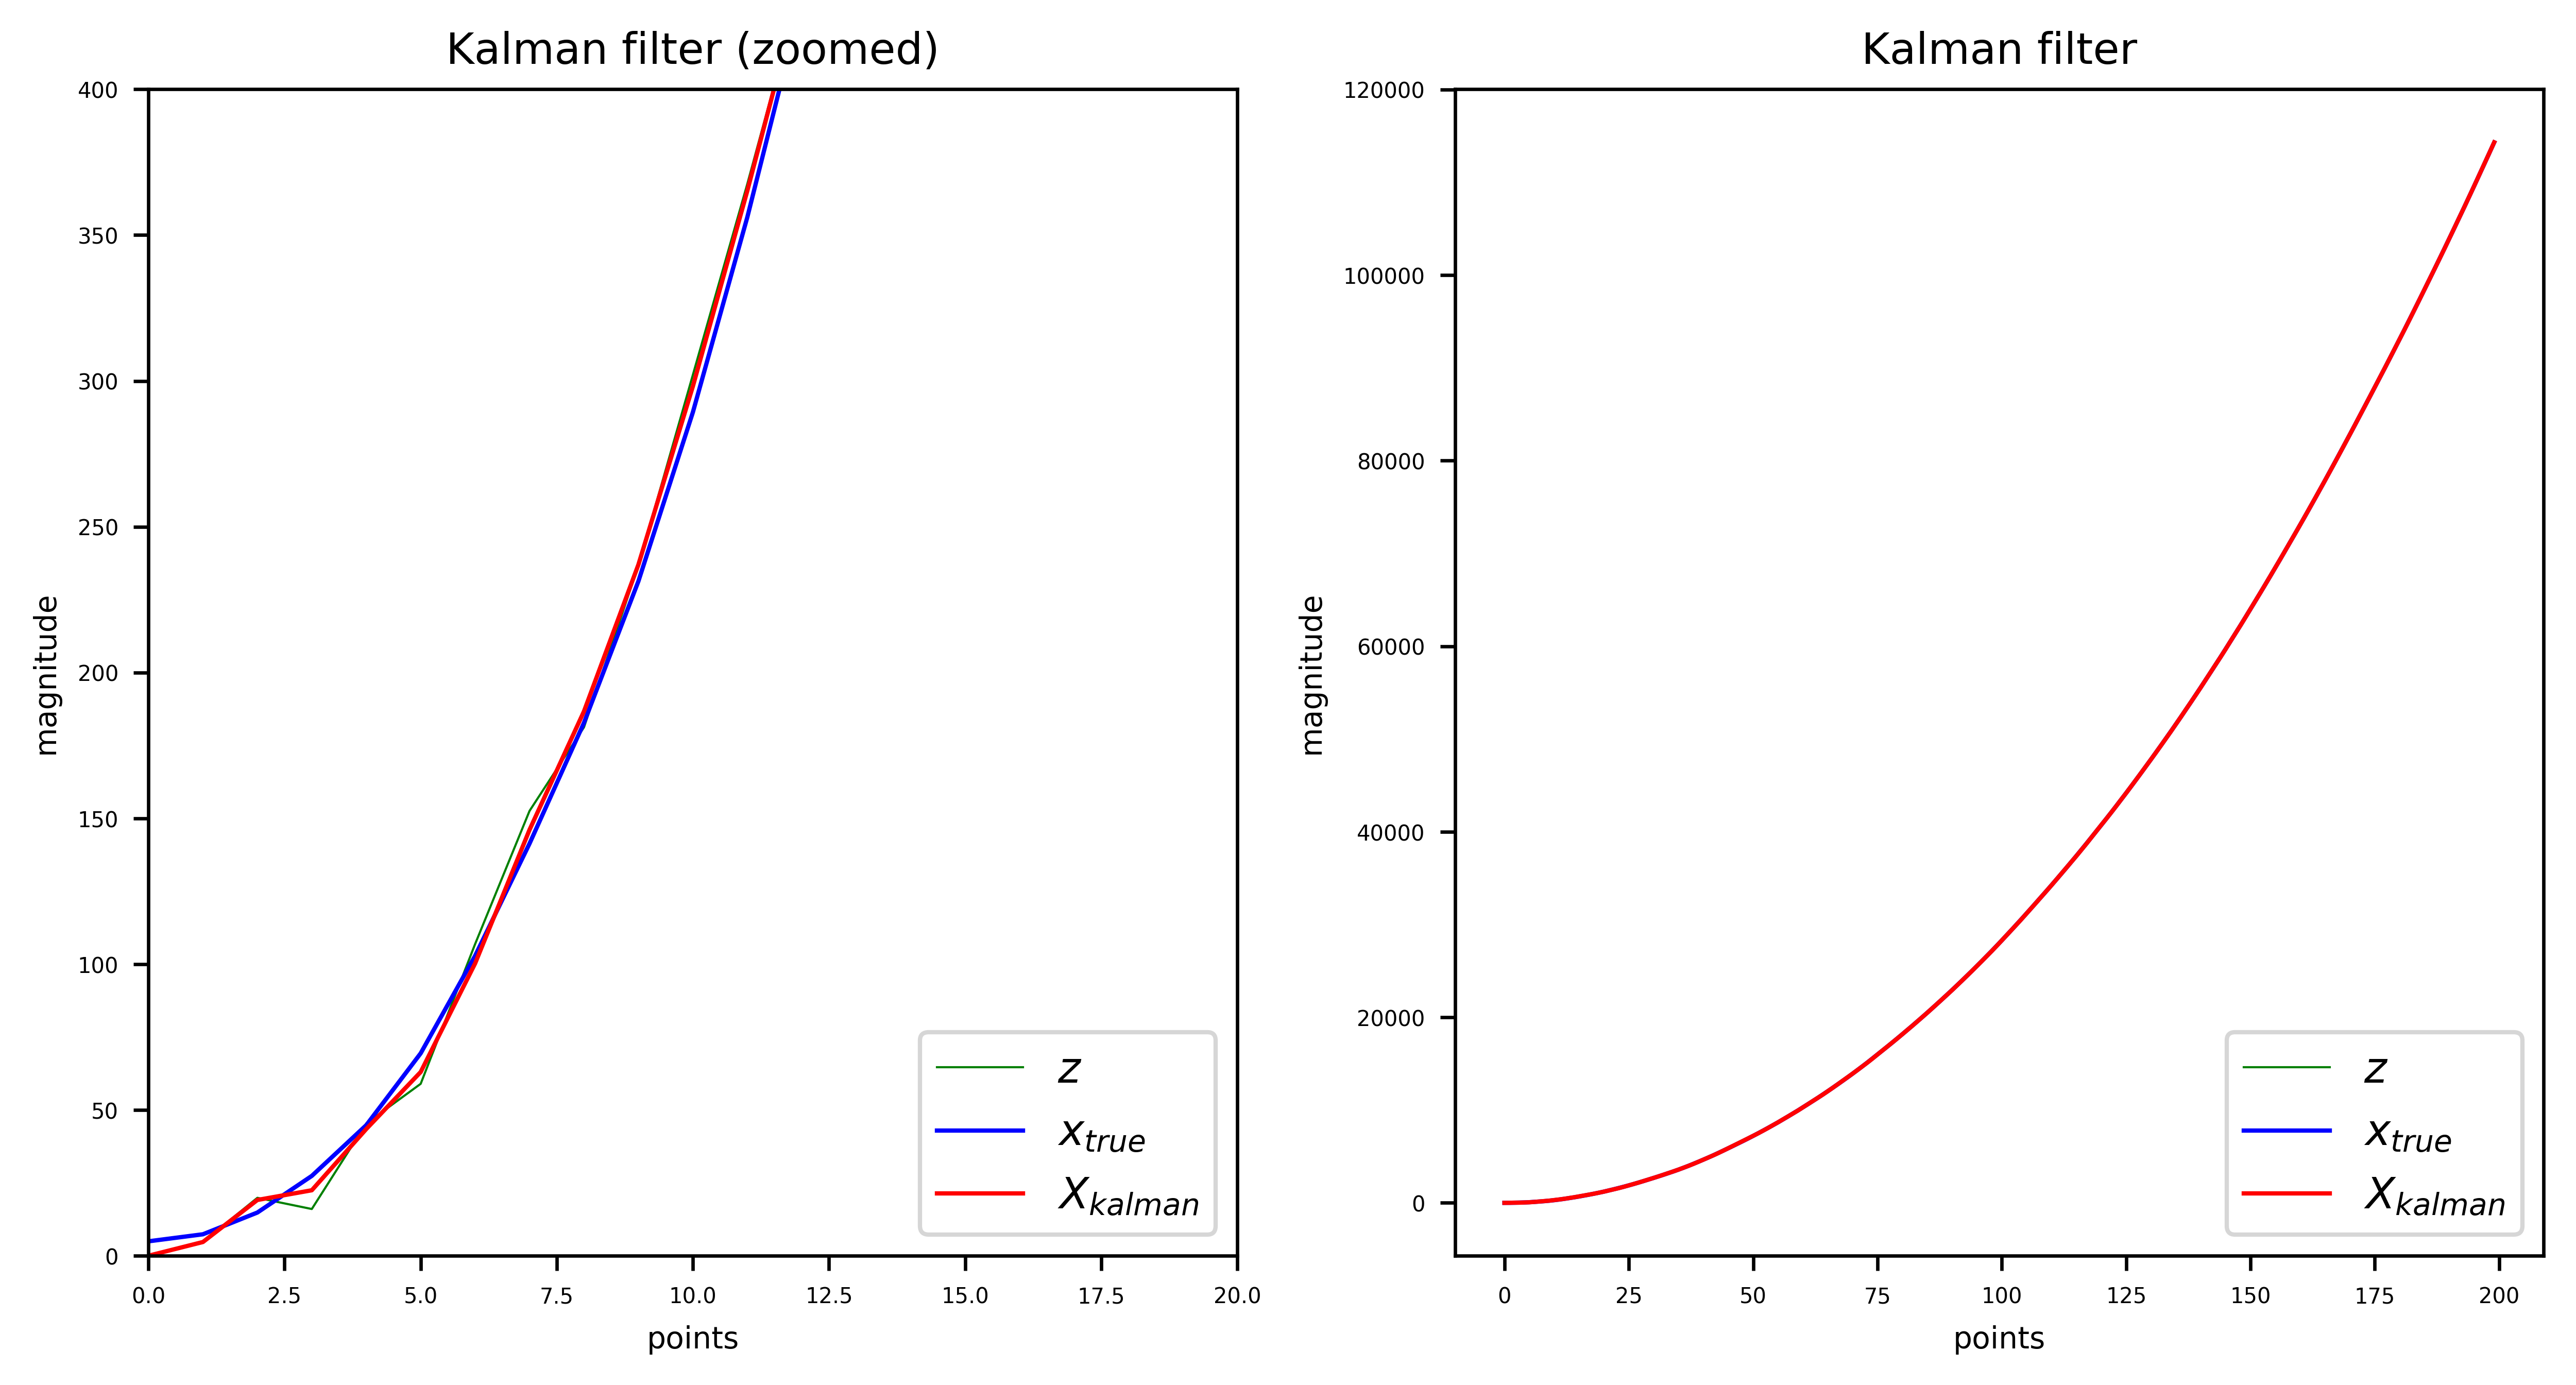

In [34]:
fig, ax = plt.subplots(1,2, figsize=(10,5),dpi=600)
ax[0].set_title('Kalman filter (zoomed)', fontsize = 10)
ax[0].plot(range(N),z,'g', label = '$z$', linewidth = 0.5 )
ax[0].plot(range(N),x,'b', label = '$x_{true}$', linewidth = 1 )
ax[0].plot(range(N),X[:,0].transpose()[0],'r', label = '$X_{kalman}$', linewidth = 1 )
#ax.plot(range(N),K[:,0].transpose()[0],'y', label = 'K', linewidth = 1 )
ax[0].set_xlim([0,20])
ax[0].set_ylim([0,400])
ax[0].legend(loc='lower right')
ax[0].set_xlabel('points', fontsize = 7)
ax[0].set_ylabel('magnitude', fontsize = 7);

ax[1].set_title('Kalman filter', fontsize = 10)
ax[1].plot(range(N),z,'g', label = '$z$', linewidth = 0.5 )
ax[1].plot(range(N),x,'b', label = '$x_{true}$', linewidth = 1 )
ax[1].plot(range(N),X[:,0].transpose()[0],'r', label = '$X_{kalman}$', linewidth = 1 )
#ax.plot(range(N),K[:,0].transpose()[0],'y', label = 'K', linewidth = 1 )
ax[1].legend(loc='lower right')
ax[1].set_xlabel('points', fontsize = 7)
ax[1].set_ylabel('magnitude', fontsize = 7);

# 500 runs for original Kalman input (from experimental noise identification
# And other conditions suggested in (a) - (e)

In [9]:
esa = exp_sigma_a_2**0.5
esn = exp_sigma_n_2**0.5
eq  = q_exp
pars = [
    [eq,esa,esn],
    [0 ,esa,esn],
    [eq,10*esa,esn],
    [eq,esa/10,esn],
    [eq,esa,10*esn],
    [eq,esa,esn/10]
       ]

0
499
0
499
0
499
0
499
0
499
0
499


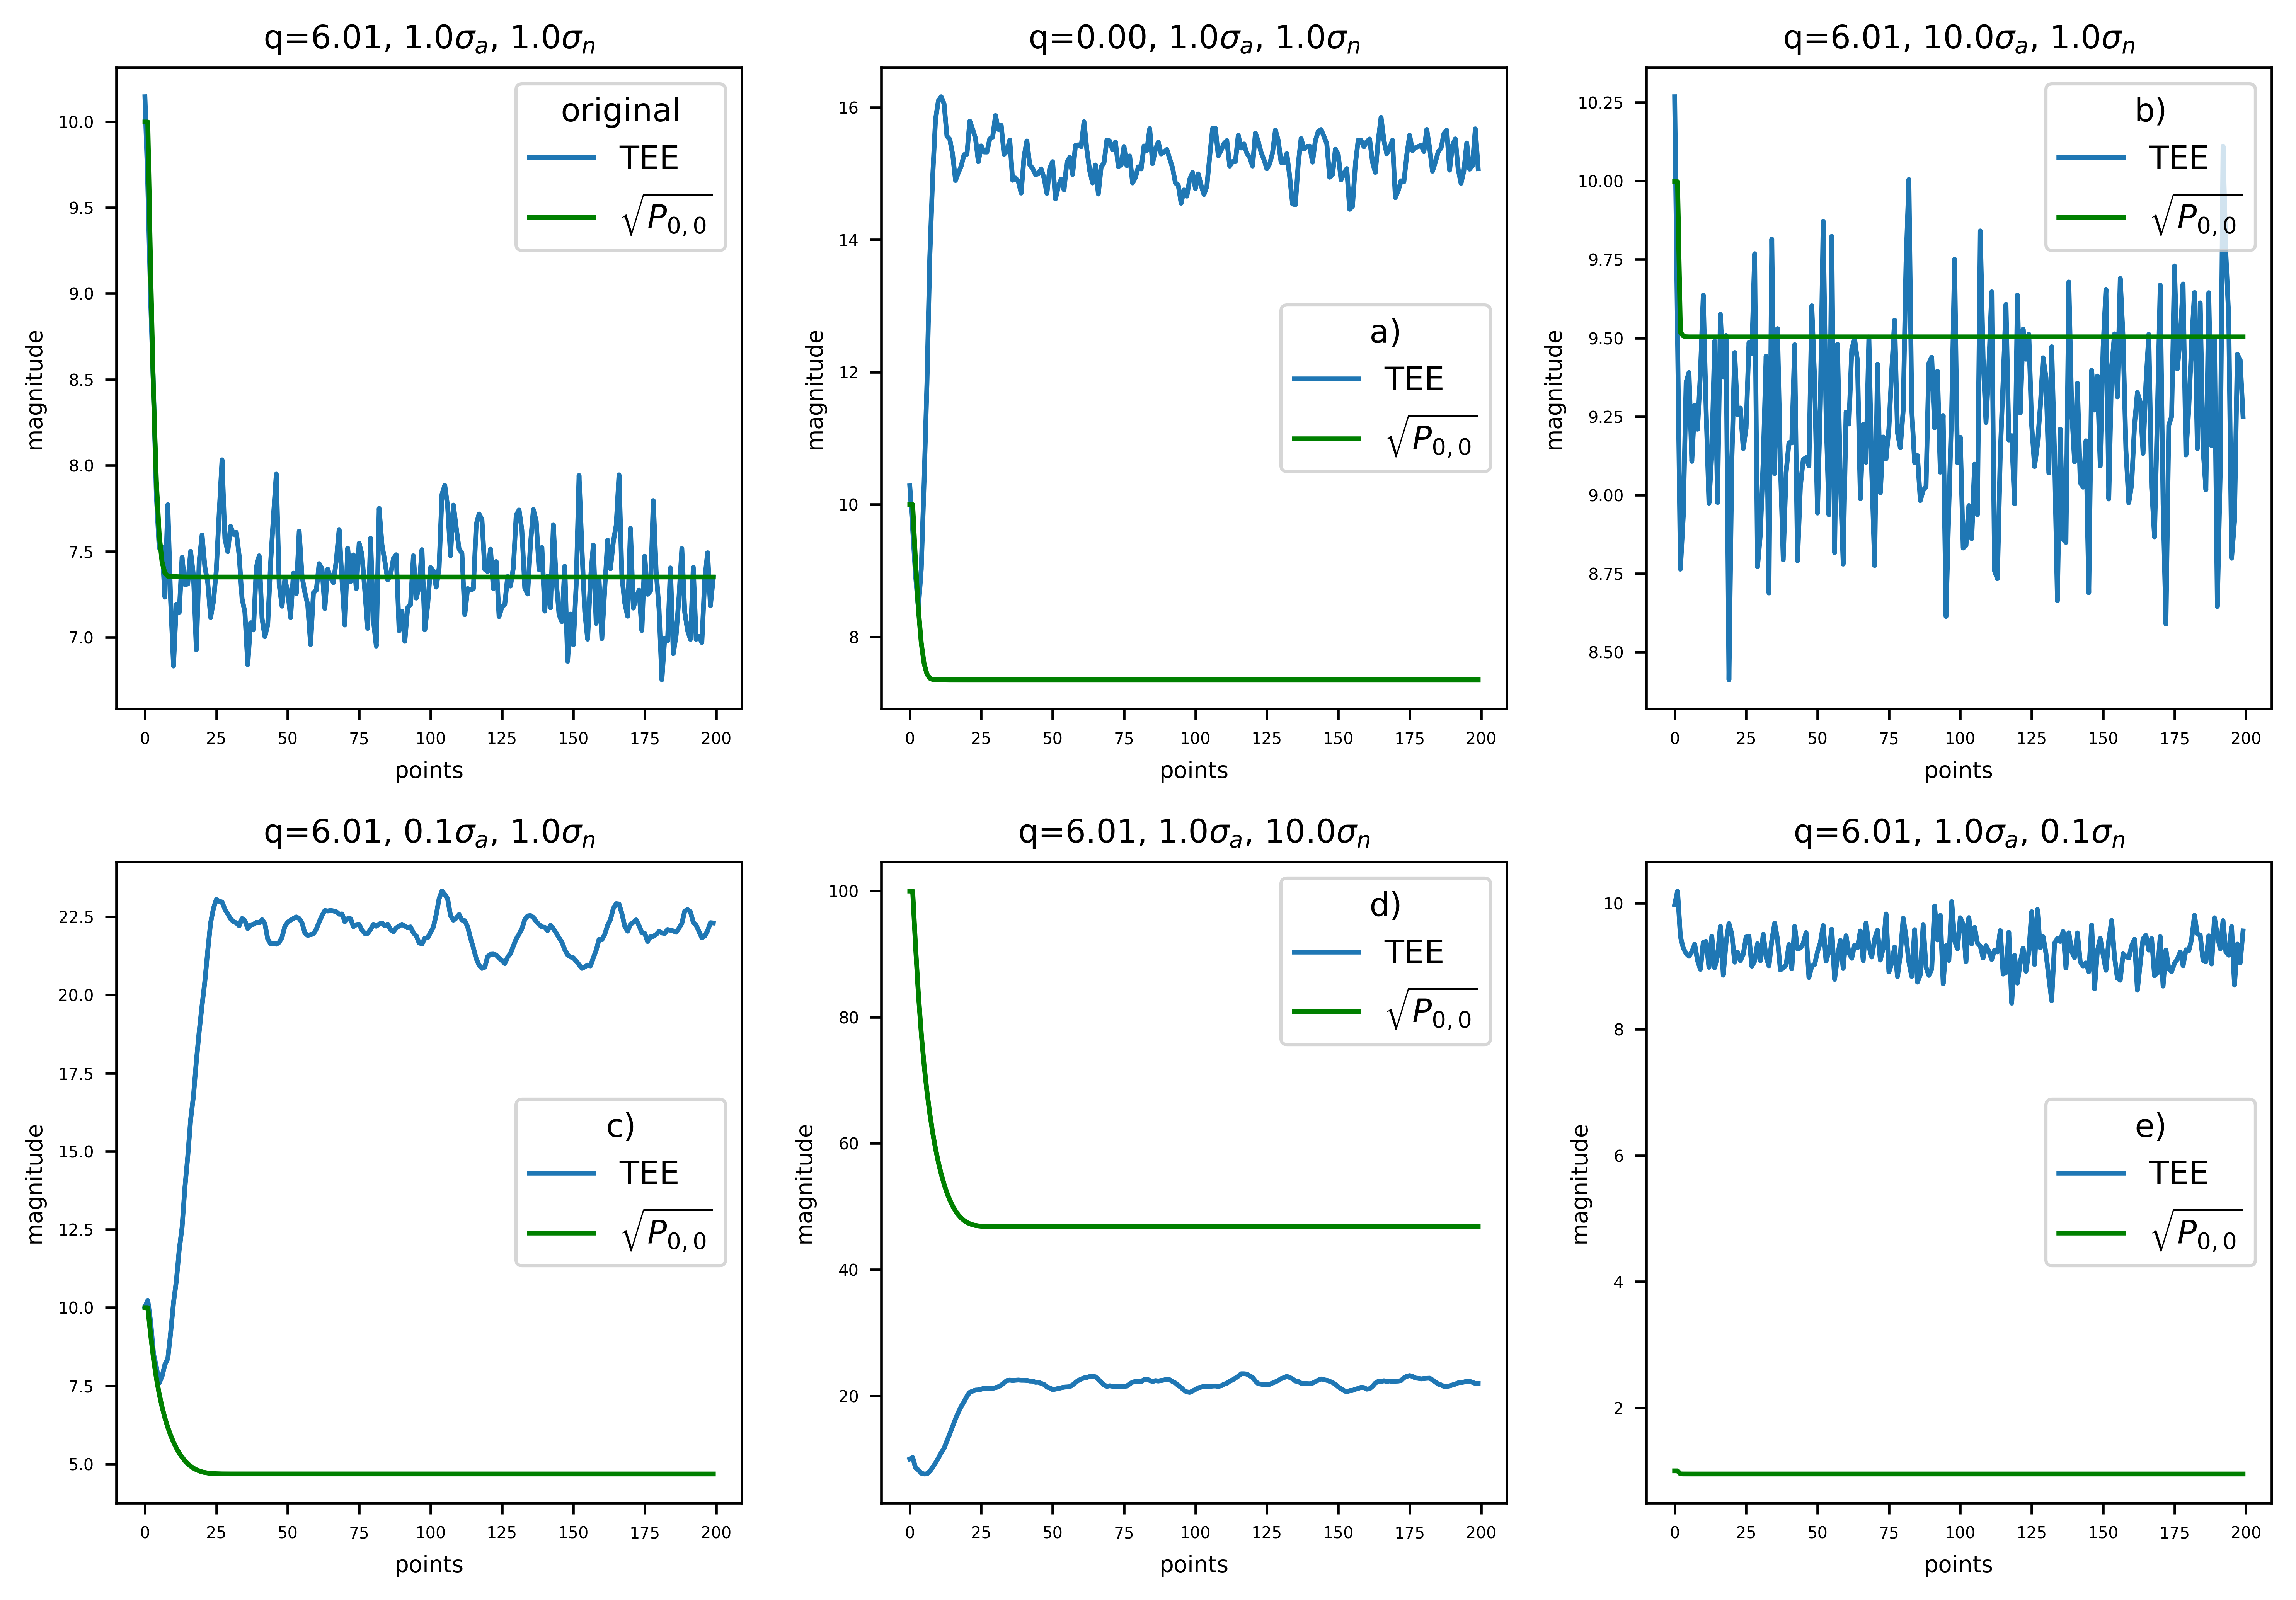

In [13]:
P_0 = np.matrix([[1e10, 0], [0,1e10]])
Repeats = 500
fig, ax = plt.subplots(2,3, figsize=(10,7), dpi = 600)
titles =  ['original','a)','b)','c)','d)','e)']
for j, (qe, sae, sne) in enumerate(pars): 
    ErrorXTrue = np.zeros((N,Repeats))
    Gq = G*qe
    Q = G.dot(G.transpose())*sae**2
    R = np.array([[sne**2]])
    for i in range(0,Repeats):
        x, z = generate_acc_trajectory(sigma_a**2, sigma_n**2, N, x_1, v_1, t, q)
        X, K, P, XF = kalman_biased(X_0, P_0, z, T, H, R, Q, Gq)
        ErrorXTrue[:,i] = (x-X[:,0,0])**2
        if i % (Repeats-1) == 0:
            print(i)
    ax[int(j/3)][j%3].set_title('q=%.2f, $%.1f\sigma_a$, $%.1f\sigma_n$'%(qe,sae/esa,sne/esn), fontsize = 10)
    ax[int(j/3)][j%3].plot( (np.sum(ErrorXTrue,axis=1)/(Repeats-1))**0.5, label = 'TEE')
    ax[int(j/3)][j%3].plot(range(N),P[:,0,0]**0.5,'g',  label = r'$\sqrt{P_{0,0}}$')
    ax[int(j/3)][j%3].legend(loc='best',title=titles[j])
    ax[int(j/3)][j%3].set_xlabel('points', fontsize = 7)
    ax[int(j/3)][j%3].set_ylabel('magnitude', fontsize = 7);
plt.tight_layout()
plt.savefig('11_6_graph.pdf',bbox_inches='tight')

## The true estimation error is smallest when we use Kalman filter with closest to real $q$, $\sigma_a$ and $\sigma_n$. Use of unbiased Kalman filter ($q = 0$) leads to twice bigger error. Overestimation of $\sigma_a$ is better than underestimation. However, vice versa for $\sigma_n$